In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, transforms
from tqdm import tqdm

In [25]:
import numpy as np
import torchvision
from torchvision import datasets, transforms


X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0], 
                np.where(X_train.targets == 1)[0])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0])


X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=128, shuffle=True, pin_memory=True)

In [26]:
X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0], 
                np.where(X_test.targets == 1)[0])
idx = np.append(idx, 
                np.where(X_test.targets == 2)[0])
idx = np.append(idx, 
                np.where(X_test.targets == 3)[0])
idx = np.append(idx, 
                np.where(X_test.targets == 4)[0])
idx = np.append(idx, 
                np.where(X_test.targets == 5)[0])


X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=128, shuffle=True)

In [27]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=6):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=16*4*4, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes)
        )
        
    def forward(self, x):
        x = self.feature_extractor(x)
        x = x.view(-1, 16*4*4)  # Flatten the tensor
        logits = self.classifier(x)
        return logits


In [28]:
device = torch.device("cpu")
model = LeNet5().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [29]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)

Number of trainable parameters: 44086


In [30]:
best_accuracy = 0
best_model = None

train_losses = []
test_losses = []

for epoch in range(10):
    model.train()
    train_loss = 0
    for idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for idx, (data, target) in enumerate(tqdm(test_loader)):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    accuracy = 100. * correct / len(test_loader.dataset)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model.state_dict()

    print(f"Epoch {epoch + 1}/{10}")
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%")


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 82.07it/s]


Epoch 1/10
Train Loss: 0.0025, Test Loss: 0.0008, Accuracy: 97.10%


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 83.91it/s]


Epoch 2/10
Train Loss: 0.0008, Test Loss: 0.0004, Accuracy: 98.26%


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 83.80it/s]


Epoch 3/10
Train Loss: 0.0005, Test Loss: 0.0003, Accuracy: 98.94%


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 83.78it/s]


Epoch 4/10
Train Loss: 0.0003, Test Loss: 0.0002, Accuracy: 99.05%


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 82.71it/s]


Epoch 5/10
Train Loss: 0.0002, Test Loss: 0.0002, Accuracy: 99.27%


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 82.27it/s]


Epoch 6/10
Train Loss: 0.0002, Test Loss: 0.0002, Accuracy: 99.40%


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 84.08it/s]


Epoch 7/10
Train Loss: 0.0001, Test Loss: 0.0001, Accuracy: 99.45%


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 83.55it/s]


Epoch 8/10
Train Loss: 0.0001, Test Loss: 0.0001, Accuracy: 99.50%


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 83.60it/s]


Epoch 9/10
Train Loss: 0.0001, Test Loss: 0.0002, Accuracy: 99.24%


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 83.84it/s]

Epoch 10/10
Train Loss: 0.0001, Test Loss: 0.0001, Accuracy: 99.47%


In [31]:
print(f"Best Accuracy: {best_accuracy:.2f}%")
torch.save(best_model, "lenet mnist 0-5.pth")

Best Accuracy: 99.50%


/tmp/ipykernel_10501/987383717.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


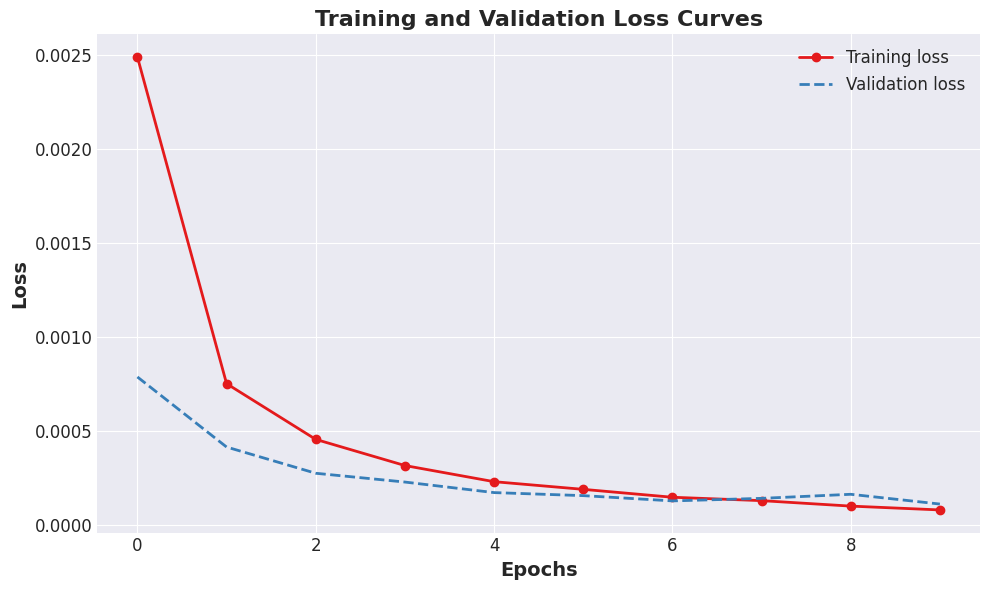

In [32]:
import matplotlib.pyplot as plt

# Use a professional style
plt.style.use('seaborn-darkgrid')

# Create a color palette
color_palette = plt.get_cmap('Set1')

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting both the curves simultaneously with enhanced aesthetics
ax.plot(train_losses, color=color_palette(0), marker='o', linestyle='-', linewidth=2, label='Training loss')
ax.plot(test_losses, color=color_palette(1), marker='', linestyle='--', linewidth=2, label='Validation loss')

# Naming the x-axis, y-axis and the whole graph with enhanced font properties
ax.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax.set_ylabel("Loss", fontsize=14, fontweight='bold')
ax.set_title("Training and Validation Loss Curves", fontsize=16, fontweight='bold')

# Displaying the legend with larger font size
ax.legend(fontsize=12)

# Enhance tick visibility and size
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust the plot for better layout
plt.tight_layout()

# Saving the graph in high quality
plt.savefig("lenet mnist 0-5 loss curve.png", dpi=300)

# Displaying the graph
plt.show()
